In [1]:
from goes2go.himawari_data import _himawari_file_df
from goes2go.gk2a_data import gk2a_timerange 
from satpy import Scene
import pandas as pd
import s3fs

In [12]:
# Dates for HIMAWARI-8
# Allowed start: 7/7/2015 02:00
# Allowed end: 13/12/2022 04:50

In [26]:
from satpy import available_readers
available_readers()

import s3fs

# Connect to AWS public buckets
fs = s3fs.S3FileSystem(anon=True)

# Define parameter options and aliases
# ------------------------------------
_himawari_satellite = {
    "noaa-himawari8": [8, "8", "H8", "HIMAWARI8", "HIMAWARI-8"], 
    "noaa-himawari9": [9, "9", "H9", "HIMAWARI9", "HIMAWARI-9"], 
}

_himawari_domain = {
    "Japan": ["C", "CONUS", "JAPAN"],
    "FLDK": ["F", "FULL", "FULLDISK", "FULL DISK"],
    "Target": ["M", "MESOSCALE", "M1", "M2", "TARGET"],
}

_himawari_resolution = {
    "R05": [0.5, 500, "0.5", "500"], 
    "R10": [1, 1000, "1", "1000"], 
    "R20": [2, 2000, "2", "2000"], 
}

_himawari_bands = dict(
    zip(
        [
            "B01",
            "B02",
            "B03",
            "B04",
            "B05",
            "B06",
            "B07",
            "B08",
            "B09",
            "B10",
            "B11",
            "B12",
            "B13",
            "B14",
            "B15",
            "B16",
        ],
        range(1, 16 + 1),
    )
)

In [31]:
def _himawari_file_df(satellite, domain, start, end, bands=None, resolutions=None, refresh=True, ignore_missing=False):
    """Get list of requested GOES files as pandas.DataFrame.

    Parameters
    ----------
    satellite : str
    product : str
    start : datetime
    end : datetime
    band : None, int, or list
        Specify the ABI channels to retrieve.
    refresh : bool
        Refresh the s3fs.S3FileSystem object when files are listed.
        Default True will refresh and not use a cached list.
    """
    params = locals()

    start = pd.to_datetime(start)
    end = pd.to_datetime(end)

    DATES = pd.date_range(f"{start:%Y-%m-%d %H:00}", f"{end:%Y-%m-%d %H:00}", freq="600s")

    # List all files for each date
    # ----------------------------
    files = []
    for DATE in DATES:
        path = f"{satellite}/AHI-L1b-{domain}/{DATE:%Y/%m/%d/%H%M}"
        if ignore_missing is True:
            try:
                files += fs.ls(path, refresh=refresh)
            except FileNotFoundError:
                print(f"Ignored missing dir: {path}")
        else:
            files += fs.ls(path, refresh=refresh)


    # Build a table of the files
    # --------------------------
    df = pd.DataFrame(files, columns=["file"])
    df.drop(index=df.index[~df["file"].str.contains(".DAT.bz2")],inplace=True)
    df[["data_format", "satellite", "date", "time", "band", "domain", "resolution", "sector"]] = (
        df["file"]
        .str.rsplit("/", expand=True)
        .iloc[:, -1]
        .str.rsplit(".", expand=True)
        .loc[:, 0]
        .str.rsplit("_", expand=True)
    )

    # Filter files by band number
    # ---------------------------
    if bands is not None:
        if not hasattr(bands, "__len__") or isinstance(bands, (str, bytes, bytearray)):
            bands = [bands]
        for i_band, band in enumerate(bands):
            if band not in _himawari_bands:
                try:
                    bands[i_band] = dict(zip(_himawari_bands.values(), _himawari_bands.keys()))[
                        band
                    ]
                except KeyError:
                    raise ValueError(f"Band {band} is not a valid AHI channel")
        df = df.loc[df.band.isin(bands)]

    # Filter files by resolution
    # --------------------------
    if resolutions is not None:
        if not hasattr(resolutions, "__len__") or isinstance(resolutions, (str, bytes, bytearray)):
            resolutions = [resolutions]
        for i_resolution, resolution in enumerate(resolutions):
            if resolution not in _himawari_resolution:
                for key, aliases in _himawari_resolution.items():
                    if resolution in aliases:
                        resolutions[i_resolution] = key
                        break
                else:
                    raise ValueError(f"Resolution {resolution} is not a valid AHI resolution")
        df = df.loc[df.resolution.isin(resolutions)]
    else:
        # If None pick the highest resolution for each
        df = df.loc[df.resolution == df.groupby("band").resolution.unique().str[0][df.band].to_numpy()]
    
    # Filter files by requested time range
    # ------------------------------------
    # Convert filename datetime string to datetime object
    df["time"] = pd.to_datetime(df.date + df.time, format="%Y%m%d%H%M")

    # Filter by files within the requested time range
    df = df.loc[df.time >= start].loc[df.time < end].reset_index(drop=True)

    for i in params:
        df.attrs[i] = params[i]

    return df

In [41]:
start_date = "2022-04-01T03:15:32"
end_date = "2022-04-01T04:15:32"

In [42]:
# Find himawari files
himawari_df = _himawari_file_df("noaa-himawari8", "FLDK", start_date, end_date, ignore_missing=True) # start_date and end_date must be end with a multiple of ten minutes, e.g. minute=0, 10, 20...

In [ ]:
import numpy as np
selected = np.random.choice(himawari_df.time.unique())

In [ ]:
# Load with satpy
scn = Scene(
    [f's3://{f}' for f in himawari_df.groupby("time").get_group(selected).file], # select all files at one time
    reader="ahi_hsd", 
    reader_kwargs=dict(
        storage_options={
            'anon': True,
            'default_block_size': 100*1024*1024,  # 100MB blocks for large files
            'default_cache_type': 'readahead',     # Optimize for sequential reading
        }
))

In [ ]:
scn.load(scn.all_dataset_names())

In [ ]:
# Resample to 2km resolution
new_scn = scn.resample(scn.coarsest_area(), resampler='native')

In [ ]:
# Convert to xarray
himawari_ds = new_scn.to_xarray()

In [ ]:
# Convert numpy.datetime64 to pandas datetime first, then format
pd.to_datetime(selected).strftime('%Y%m%d%H%M%S')

In [ ]:
himawari_ds.B01.plot()

### GeoKompsat 2

In [6]:
ami_files = gk2a_timerange(
    start="2023-10-01 10:00:00",
    end="2023-10-01 10:10:00",
    domain="FD",
    download=False
)
ami_files

In [ ]:
filenames = list("s3://"+ file for file in ami_files["file"])

In [18]:
filenames = list("s3://"+ file for file in ami_files["file"])
storage_options = {'anon': True}
scn = Scene(reader='ami_l1b', filenames=filenames, reader_kwargs={'storage_options': storage_options})

In [ ]:
scn = Scene(reader='ami_l1b', filenames=[filenames[0]], reader_kwargs={'storage_options': storage_options})
scn.load(['IR087',
 'IR096',
 'IR105',
 'IR112',
 'IR123',
 'IR133',
 'NR013',
 'NR016',
 'SW038',
#  'VI004',
#  'VI005',
#  'VI006',
#  'VI008',
 'WV063',
 'WV069',
 'WV073'])

In [ ]:
ds = scn.to_xarray()
ds.to_netcdf('test.nc')

In [ ]:
import xarray as xr
test = xr.open_dataset('test.nc')
test.IR087

In [182]:
def reduce_file_size(ds, compression_level=9):
    """
    Reduce the file size of the dataset by converting to float32 and compressing.
    
    Args:
        ds (xarray.Dataset): The dataset to reduce.
        compression_level (int): Compression level for saving the dataset.
    
    Returns:
        xarray.Dataset: Reduced dataset.
    """
    # Reduce file size by converting to float32
    ds = ds.astype("float32")
    # Remove unnecessary variables
    ds = ds.drop_vars(["FLDK"])

    encoding = {}

    # Add data variable compression
    for var in ds.data_vars:
        if ds[var].dtype in ['float64', 'float32']:
            encoding[var] = {'dtype': 'float32', 'zlib': True, 'complevel': compression_level, 'shuffle': True}
    # Add coordinate compression
    for coord in ds.coords:
        if ds[coord].dtype in ['float64', 'float32']:
            encoding[coord] = {'dtype': 'float32', 'zlib': True, 'complevel': compression_level, 'shuffle': True}

    return ds, encoding

In [180]:
import xarray as xr
test_ds = xr.open_dataset('20210128132000_patch_2150_2389.nc')

In [ ]:
test_ds

In [187]:
comp_ds, encoding = reduce_file_size(test_ds, compression_level=9)

In [188]:
comp_ds.to_netcdf('20210128132000_patch_2150_2389_reduced.nc', encoding=encoding)

#### Look at the selected HIMAWARI files

In [9]:
path = '/home/users/annaju/eo-data-prep/notebooks/himawari/merged_himawari_tracks.csv'

In [10]:
csv = pd.read_csv(path)

In [ ]:
csv.groupby('time').size().sort_values(ascending=True)

time
2019-09-01 04:40:00    16
2019-08-30 18:40:00    16
2019-08-30 17:30:00    16
2017-10-04 17:10:00    16
2017-10-04 17:00:00    16
2017-10-04 15:50:00    16
2019-09-01 06:10:00    16
2019-09-01 06:00:00    16
2019-09-01 04:50:00    16
2019-08-30 19:00:00    16
dtype: int64

In [52]:
subset = csv[csv.time == '2019-09-01 04:40:00']

In [54]:
len(subset)

16

In [55]:
scn = Scene(
    [f's3://{f}' for f in subset.file], # select all files at one time
    reader="ahi_hsd", 
    reader_kwargs=dict(
        storage_options={
            'anon': True,
            'default_block_size': 100*1024*1024,  # 100MB blocks for large files
            'default_cache_type': 'readahead',     # Optimize for sequential reading
        }
))

In [56]:
# load available datasets
scn.load(scn.all_dataset_names())

# Resample to 2km resolution
new_scn = scn.resample(scn.coarsest_area(), resampler='native')

In [57]:
ds = new_scn.to_xarray()

/home/users/annaju/miniforge3/envs/jasmin-env/lib/python3.13/site-packages/satpy/resample/native.py:129: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data.reshape(new_shape), axis=(1, 3))


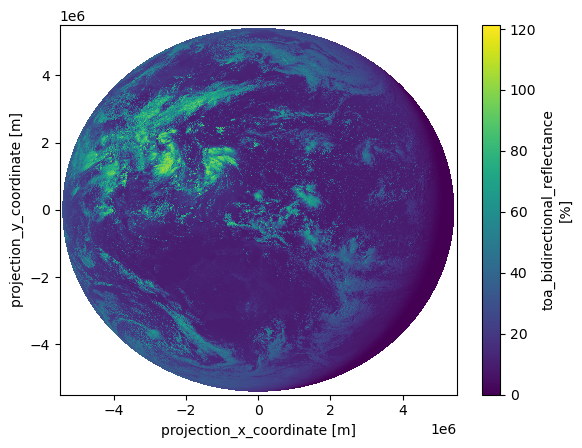

/home/users/annaju/miniforge3/envs/jasmin-env/lib/python3.13/site-packages/satpy/resample/native.py:129: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data.reshape(new_shape), axis=(1, 3))


In [ ]:
ds.B01.plot()

In [ ]:
ds = ds.astype("float32")
ds.to_netcdf('himawari_2019-09-01_04-40.nc', encoding={'B01': {'dtype': 'float32', 'zlib': True, 'complevel': 9, 'shuffle': True}})

/home/users/annaju/miniforge3/envs/jasmin-env/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in log
  return self.func(*new_argspec)
